In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [28]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [29]:
prior_mu = torch.zeros(2)
prior_cov = torch.eye(2)
theta = torch.distributions.MultivariateNormal(prior_mu, prior_cov)
theta

MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2]))

In [30]:
theta.loc, theta.covariance_matrix

(tensor([0., 0.]),
 tensor([[1., 0.],
         [0., 1.]]))

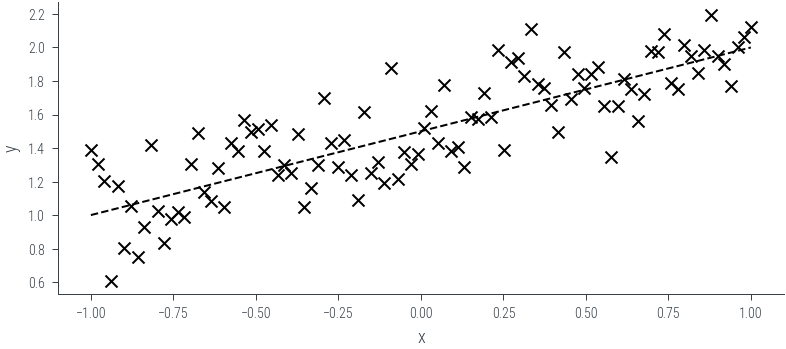

In [31]:
### True data

# True parameters
true_theta = torch.tensor([1.5, 0.5])

# Generate data
x = torch.linspace(-1, 1, 100)
torch.manual_seed(42)
y = true_theta[0] + true_theta[1] * x + torch.randn_like(x) * 0.2

plt.scatter(x, y, marker='x', color='k')
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x, true_theta[0] + true_theta[1] * x, color='k', linestyle='--')


### Computing the evidence term


$$ I = \int p(\mathcal{D} \mid \theta) p(\theta) \mathrm{d}\theta $$

$$ I \approx \frac{1}{N} \sum_{i=1}^N p(\mathcal{D} \mid \theta_i) $$

where $\theta_i \sim p(\theta)$


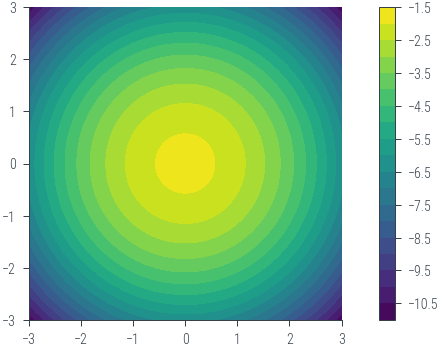

In [32]:
# Plot the prior in 2d contour

theta1 = torch.linspace(-3, 3, 100)
theta2 = torch.linspace(-3, 3, 100)

theta1, theta2 = torch.meshgrid(theta1, theta2)

theta_values = torch.stack((theta1, theta2), dim=-1)  # Shape: (100, 100, 2)

z = theta.log_prob(theta_values.view(-1, 2))  # Shape: (10000,)
z = z.view(100, 100)  # Reshape to (100, 100)

plt.contourf(theta1.numpy(), theta2.numpy(), z.numpy(), 20)
plt.gca().set_aspect('equal')

plt.colorbar()


In [33]:
theta.sample((10,))

tensor([[ 0.7262,  0.0912],
        [-0.3891,  0.5279],
        [-0.3609, -0.0606],
        [ 0.0733,  0.8187],
        [ 1.4805,  0.3449],
        [-1.4241, -0.1163],
        [ 0.2176, -0.0467],
        [-1.4335, -0.5665],
        [-0.4253,  0.2625],
        [-1.4391,  0.5214]])

In [34]:
theta_sample = theta.sample((1000,))
theta_sample

tensor([[ 1.0414, -0.3997],
        [-2.2933,  0.4976],
        [-0.4257, -1.3371],
        ...,
        [-0.5654,  0.2558],
        [-1.5377, -0.1796],
        [-0.1124,  0.2712]])

In [35]:
def log_likelihood(theta, x, y):
    """Compute the likelihood of a linear regression model."""
    theta = theta.view(1, 2)  # Shape: (1, 2)
    x = x.view(-1, 1)  # Shape: (100, 1)
    y = y.view(-1, 1)  # Shape: (100, 1)
    mean = theta[:, 0] + theta[:, 1] * x  # Shape: (100, 1)
    return torch.distributions.Normal(mean, 0.2).log_prob(y).sum()  # Shape: (1,)


In [36]:
log_likelihood(theta_sample[0], x, y), log_likelihood(theta_sample[1], x, y), log_likelihood(true_theta, x, y)

(tensor(-595.4868), tensor(-18079.3672), tensor(20.7114))

In [37]:
theta_sample[0], theta_sample[1], true_theta

(tensor([ 1.0414, -0.3997]),
 tensor([-2.2933,  0.4976]),
 tensor([1.5000, 0.5000]))

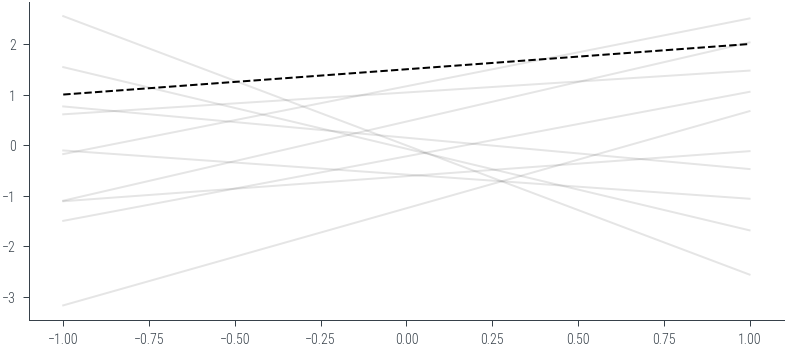

In [43]:
N = 10
for i in range(N):
    theta_s = theta.sample()
    plt.plot(x, theta_s[0] + theta_s[1] * x, color='k', alpha=0.1)
plt.plot(x, true_theta[0] + true_theta[1] * x, color='k', linestyle='--')

In [62]:
# It seems we will have numerical problems. Let us use the log-sum-exp trick to compute the log evidence.
N = 12000
# Initialize a list to store log likelihood values
log_likelihood_values = []

# Monte Carlo estimation of the log marginal likelihood
for i in range(N):
    # Sample θ from the prior distribution
    theta_sample = theta.sample()

    # Calculate the log likelihood using your provided function
    log_likelihood_value = log_likelihood(theta_sample, x, y)

    # Append the log likelihood value to the list
    log_likelihood_values.append(log_likelihood_value.item())

# Use the log-sum-exp trick to compute the log marginal likelihood
log_marginal_likelihood = -torch.log(torch.tensor(N)) + torch.logsumexp(torch.tensor(log_likelihood_values), dim=0)

print("Log marginal likelihood:", log_marginal_likelihood.item())


Log marginal likelihood: 12.861690521240234


In [106]:
# Design matrix X
X = torch.stack([torch.ones_like(x), x], dim=1)

# Variance of the Gaussian noise in the likelihood
sigma_squared = 0.2**2

# Calculate the precision matrix A from the prior covariance matrix
A = torch.inverse(prior_cov)

# Calculate the marginal likelihood (evidence) using the provided expression
marginal_likelihood = torch.distributions.MultivariateNormal(torch.matmul(X, prior_mu), torch.matmul(torch.matmul(X, prior_cov), X.t()) + sigma_squared * torch.eye(len(x)))


In [107]:
marginal_likelihood

MultivariateNormal(loc: torch.Size([100]), covariance_matrix: torch.Size([100, 100]))

In [108]:
log_prob_data = marginal_likelihood.log_prob(y)


In [109]:
log_prob_data

tensor(12.3548)